In [1]:
import spacy
from tqdm import tqdm 
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import pandas as pd
from IPython.display import display 

print("Librairies importées")

Librairies importées


In [31]:
print("Chargement de mon modèle à moi...")
nlp_itinerary = spacy.load("../../models/saved_models/model-best/")
print("Chargement du modèle préentrainé de spaCy fr...")
nlp_fr = spacy.load("fr_core_news_md")

print("Les 2 modèles ont été chargés")

Chargement de mon modèle à moi...
Chargement du modèle préentrainé de spaCy fr...
Les 2 modèles ont été chargés


In [32]:
@Language.factory("language_detector")
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp_fr.add_pipe('language_detector', last=True)

In [33]:
# Pour extraire les entités de départ et destination du texte
def extract_locations(text, lang_model, itinerary_model, verbose=False):
    doc_lang = lang_model(text)
    doc_itinerary = itinerary_model(text)

    # dictionnaire pour stocker les entités détectées
    entities_detected = {
        "Entités linguistiques": [],
        "Entités modèle d'itinéraire": []
    }

    if verbose:
        print("Entités détectées avec le modèle linguistique :")
        spacy.displacy.render(doc_lang, style='ent', jupyter=True)
        print("Entités détectées avec notre modèle à nous :")
        spacy.displacy.render(doc_itinerary, style='ent', jupyter=True)

    departure, destination = None, None

    # on verifie si le texte est bien en français
    if doc_lang._.language['language'] != 'fr':
        return "NON_FRANÇAIS", entities_detected

    # on parcours les entités détectées par le modèle linguistique
    for ent in doc_lang.ents:
        entities_detected["Entités linguistiques"].append(ent.text)

    # on parcours les entités détectées par notre modele à nous
    for ent in doc_itinerary.ents:
        if ent.label_ == "DEPARTURE":
            departure = ent.text
        elif ent.label_ == "DESTINATION":
            destination = ent.text
        entities_detected["Entités modèle d'itinéraire"].append(ent.text)

    if not departure or not destination:
        return "PAS_DE_TRAJET", entities_detected

    return {"départ": departure, "destination": destination}, entities_detected

test_text = "Je voudrais aller de Paris à Marseille."
result = extract_locations(test_text, nlp_fr, nlp_itinerary, verbose=True)
print("Résultat de l'extraction : ", result)


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Résultat de l'extraction :  ({'départ': 'Paris', 'destination': 'Marseille'}, {'Entités linguistiques': ['Paris', 'Marseille'], "Entités modèle d'itinéraire": ['Paris', 'Marseille']})


In [38]:
# Pour traiter un fichier et extraire les informations de départ et destination
def process_file(filepath, lang_model, itinerary_model, verbose=False):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    result_trips = []
    for line in lines:
        elements = line.strip().split(',', 1)
        id_ = elements[0] if elements[0].isdigit() else 0
        text = elements[1] if len(elements) > 1 else elements[0]

        trips = extract_locations(text, lang_model, itinerary_model, verbose)
        if trips == "NON_FRANÇAIS" or trips == "PAS_DE_TRAJET":
            result_trips.append(f"{id_},{trips}")
        elif isinstance(trips, dict):
            result_trips.append(f"{id_},{trips['départ']},{trips['destination']}")
        else:
            result_trips.append(f"{id_},ERREUR")

    return result_trips

process_file('../../utils/test_data/nlp_input_data.txt', nlp_fr, nlp_itinerary, verbose=True)

Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


['1,ERREUR',
 '2,ERREUR',
 '3,ERREUR',
 '4,ERREUR',
 '5,ERREUR',
 '6,ERREUR',
 '7,ERREUR',
 '8,ERREUR',
 '9,ERREUR',
 '0,ERREUR',
 '10,ERREUR']

Erreur ligne 2 :
Extrait : 2,Lyon,Bordeaux
Attendu : 2,Lyon,Strasbourg

Taux de réussite : 50.0% (1 erreurs sur 2 lignes).



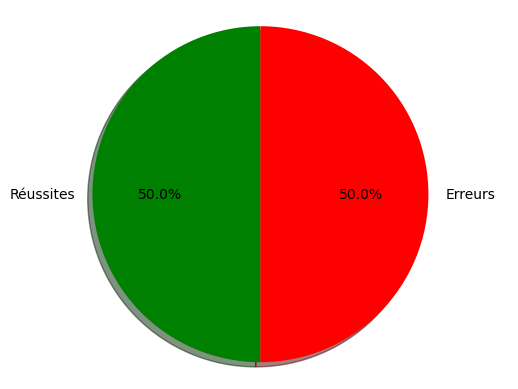

In [39]:
# Pour comparer des résultats extraits avec les résultats attendus
def compare_trips(extracted, expected):
    errors = 0
    min_length = min(len(extracted), len(expected))

    if min_length == 0:
        print("Erreur : l'une des listes est vide. Impossible de comparer.")
        return

    for i in range(min_length):
        if extracted[i] != expected[i]:
            errors += 1
            print(f"Erreur ligne {i+1} :")
            print(f"Extrait : {extracted[i]}")
            print(f"Attendu : {expected[i]}")

    # on verifie si y a des lignes supplémentaires dans l'une des listes
    if len(extracted) > len(expected):
        print(f"\n{len(extracted) - len(expected)} lignes supplémentaires dans les résultats extraits.\n")
        for i in range(len(expected), len(extracted)):
            print(f"Ligne extraite {i+1} : {extracted[i]}")
    elif len(expected) > len(extracted):
        print(f"\n{len(expected) - len(extracted)} lignes manquantes dans les résultats extraits.\n")
        for i in range(len(extracted), len(expected)):
            print(f"Ligne attendue {i+1} : {expected[i]}")

    # Calcul du taux de réussite
    success_rate = round((min_length - errors) / min_length * 100, 2)
    print(f"\nTaux de réussite : {success_rate}% ({errors} erreurs sur {min_length} lignes).\n")

    # Affichage instantané d'un graphique circulaire
    labels = 'Réussites', 'Erreurs'
    sizes = [min_length - errors, errors]
    colors = ['green', 'red']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.show()

compare_trips(["1,Paris,Marseille", "2,Lyon,Bordeaux"], ["1,Paris,Marseille", "2,Lyon,Strasbourg"])

In [40]:
# Pour corriger des villes en utilisant la liste de villes
def correct_cities(trips, city_file_path, verbose=False):
    with open(city_file_path, 'r', encoding='utf-8') as file:
        city_list = [line.strip().upper() for line in file.readlines()]

    corrected_trips = []
    for trip in trips:
        parts = trip.upper().replace('É', 'E').replace('-', ' ').split(',')
        corrected_trip = ','.join([difflib.get_close_matches(item, city_list, n=1, cutoff=0.8)[0] if difflib.get_close_matches(item, city_list, n=1, cutoff=0.8) else item for item in parts])
        corrected_trips.append(corrected_trip)

        if verbose:
            print(f"Avant : {trip}")
            print(f"Après correction : {corrected_trip}")

    return corrected_trips

test_trips = ["1,Touluse,Bordaux", "2,Pariss,Marseilles"]
corrected = correct_cities(test_trips, '../../utils/extra_datas/urban_geodata_basic_v1.0.txt', verbose=True)
print("Résultat après correction : ", corrected)

Avant : 1,Touluse,Bordaux
Après correction : 1,TOULOUSE,BORDEAUX
Avant : 2,Pariss,Marseilles
Après correction : 2,PARIS,MARSEILLE
Résultat après correction :  ['1,TOULOUSE,BORDEAUX', '2,PARIS,MARSEILLE']


Lecture du fichier d'entrée :
1,Je cherche un trajet de Lyon à Nice
2,Puis-je me rendre à Grenoble depuis Chambéry en train ?
3,Je veux voyager de Paris à Lille demain
4,Comment aller de Toulouse à Nice ?
5,Y a-t-il un train pour aller de Strasbourg à Metz ?
6,Je pars de Marseille pour aller à Montpellier
7,Je cherche un bus de Lyon à Dijon
8,Y a-t-il des trains entre Bordeaux et Toulouse ?
9,Je veux dormir 
Si pas de numéro de séquence, on considère que c'est zéro
10,is there any train going from Paris to Marseille ?

ANALYSE BRUTE (SANS PRÉTRAITEMENT)

Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Entités détectées avec le modèle linguistique :


Entités détectées avec notre modèle à nous :


Trajets extraits (brut) : ['1,ERREUR', '2,ERREUR', '3,ERREUR', '4,ERREUR', '5,ERREUR', '6,ERREUR', '7,ERREUR', '8,ERREUR', '9,ERREUR', '0,ERREUR', '10,ERREUR']
Trajets de référence : ['1,Lyon,Nice', '2,Chambéry,Grenoble', '3,Paris,Lille', '4,Toulouse,Nice', '5,Strasbourg,Metz', '6,Marseille,Montpellier', '7,Lyon,Dijon', '8,Bordeaux,Toulouse', '9,PAS_DE_TRAJET', '10,NON_FRANÇAIS']
Erreur ligne 1 :
Extrait : 1,ERREUR
Attendu : 1,Lyon,Nice
Erreur ligne 2 :
Extrait : 2,ERREUR
Attendu : 2,Chambéry,Grenoble
Erreur ligne 3 :
Extrait : 3,ERREUR
Attendu : 3,Paris,Lille
Erreur ligne 4 :
Extrait : 4,ERREUR
Attendu : 4,Toulouse,Nice
Erreur ligne 5 :
Extrait : 5,ERREUR
Attendu : 5,Strasbourg,Metz
Erreur ligne 6 :
Extrait : 6,ERREUR
Attendu : 6,Marseille,Montpellier
Erreur ligne 7 :
Extrait : 7,ERREUR
Attendu : 7,Lyon,Dijon
Erreur ligne 8 :
Extrait : 8,ERREUR
Attendu : 8,Bordeaux,Toulouse
Erreur ligne 9 :
Extrait : 9,ERREUR
Attendu : 9,PAS_DE_TRAJET
Erreur ligne 10 :
Extrait : 0,ERREUR
Attendu : 10,

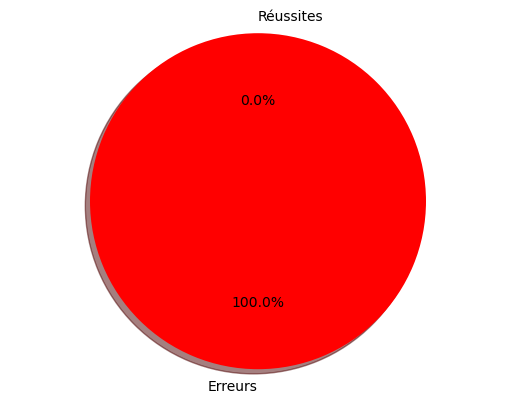


ANALYSE APRÈS PRÉTRAITEMENT

Erreur ligne 1 :
Extrait : 1,ERREUR
Attendu : 1,LYON,NICE
Erreur ligne 2 :
Extrait : 2,ERREUR
Attendu : 2,CHAMBÉRY,GRENOBLE
Erreur ligne 3 :
Extrait : 3,ERREUR
Attendu : 3,PARIS,LILLE
Erreur ligne 4 :
Extrait : 4,ERREUR
Attendu : 4,TOULOUSE,NICE
Erreur ligne 5 :
Extrait : 5,ERREUR
Attendu : 5,STRASBOURG,METZ
Erreur ligne 6 :
Extrait : 6,ERREUR
Attendu : 6,MARSEILLE,MONTPELLIER
Erreur ligne 7 :
Extrait : 7,ERREUR
Attendu : 7,LYON,DIJON
Erreur ligne 8 :
Extrait : 8,ERREUR
Attendu : 8,BORDEAUX,TOULOUSE
Erreur ligne 9 :
Extrait : 9,ERREUR
Attendu : 9,PAS_DE_TRAJET
Erreur ligne 10 :
Extrait : 0,ERREUR
Attendu : 10,NON_FRANÇAIS

1 lignes supplémentaires dans les résultats extraits.

Ligne extraite 11 : 10,ERREUR

Taux de réussite : 0.0% (10 erreurs sur 10 lignes).



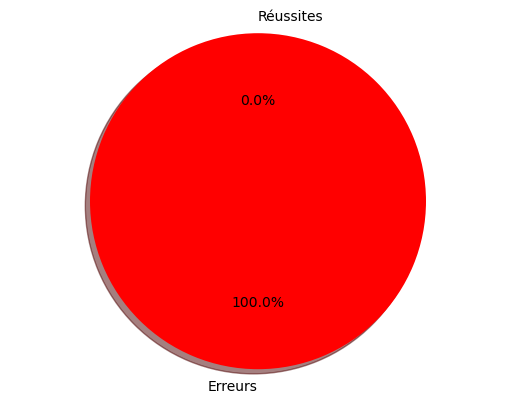

In [43]:
# Pour analyser un fichier et la comparaison avec les résultats attendus
def analyze_nlp(file_path_input, file_path_output, city_file_path):
    with open(file_path_input, 'r') as file:
        print(f"Lecture du fichier d'entrée :\n{file.read()}")

    with open(file_path_output, 'r', encoding='utf-8') as file:
        reference_trips = [line.strip().rstrip(',') for line in file.readlines()]

    # on ajoute une vérification des données
    print("\nANALYSE BRUTE (SANS PRÉTRAITEMENT)\n")
    raw_output_trips = process_file(file_path_input, nlp_fr, nlp_itinerary, True)

    # on affiche des resultats pour débogage
    print("Trajets extraits (brut) :", raw_output_trips)
    print("Trajets de référence :", reference_trips)

    if not raw_output_trips or not reference_trips:
        print("Erreur : l'une des listes est vide. Impossible de comparer.")
        return

    compare_trips(raw_output_trips, reference_trips)

    print("\nANALYSE APRÈS PRÉTRAITEMENT\n")
    processed_output_trips = correct_cities(raw_output_trips, city_file_path)
    processed_reference_trips = correct_cities(reference_trips, city_file_path)

    if not processed_output_trips or not processed_reference_trips:
        print("Erreur : l'une des listes est vide après prétraitement. Impossible de comparer.")
        return

    compare_trips(processed_output_trips, processed_reference_trips)

analyze_nlp('../../utils/test_data/nlp_input_data.txt', '../../utils/test_data/nlp_ouput_data.txt', '../../utils/extra_datas/urban_geodata_basic_v1.0.txt')